In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from scipy import stats
# from fnn_datagenerator import BatchedFakeParticleDataset_All, flat_output_vars
from n1_2 import CustomKinematicNet, activation, hidden_layers, dfpath, modelsavepath, flat_output_vars, train_batch_size, prefix
from fnn_datagenerator import flat_output_vars, GeV_outputvars

import os
import sys
#os add to path /home/ddemler/HNLclassifier/DNN/
sys.path.append('/home/ddemler/HNLclassifier/DNN/')
from pytorch2python import create_data_loaders, create_test_loader
from tqdm.notebook import tqdm

sys.path.append('/home/ddemler/HNLclassifier/SignificancePlotting/')
sys.path.append('/home/ddemler/HNLclassifier/utils/')

from Significance_func import *
from copy import deepcopy




14 112


In [2]:
real_prefix="Transfer_try3_2"

In [3]:
newmodelsavepath='/home/ddemler/HNLclassifier/saved_files/transfer_lmodel/Aug29/' + real_prefix + '_model.pt'

In [4]:
data_basepath='/home/ddemler/HNLclassifier/saved_files/extracted_data/TEST10_'
# TEST10_data_newAug28
fulldatapath=data_basepath + 'train_Aug29'
valdatapath=data_basepath + 'val_Aug29'
testdatapath=data_basepath + 'test_Aug29'

fulldata=pd.read_pickle(fulldatapath)
valdata=pd.read_pickle(valdatapath)

In [5]:
realdata_allvars = list(fulldata.columns)
print(realdata_allvars)


['event', 'genWeight', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'phi_1', 'phi_2', 'phi_3', 'phi_MET', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'mass_12', 'mass_13', 'mass_23', 'mass_123', 'Mt_tot', 'HNL_CM_a

In [6]:
print(fulldata['channel'].value_counts())

channel
2    369401
0    200473
1    170895
4    124217
3     34356
Name: count, dtype: int64


In [7]:

# old_model_input= ['1_eta', '1_mass', '1_phi', '1_pt', '2_eta?', '2_mass', '2_phi', '2_pt', '3_eta', '3_mass', '3_phi', '3_pt', 'MET_phi', 'MET_pt']
renamed_old_input_names=['eta_1', 'mass_1', 'phi_1', 'pt_1', 'eta_2', 'mass_2', 'phi_2', 'pt_2', 'eta_3', 'mass_3', 'phi_3', 'pt_3', 'phi_MET', 'pt_MET']
additionalinput_vars=['charge_1', 'charge_2', 'charge_3', 'channel','n_tauh', 'mass_hyp']
output=fulldata['signal_label']



def datamaker(data):
    outputdata_shape= (len(data['pt_MET']), len(flat_output_vars))
    inputdata_shape= (len(data['pt_MET']), len(renamed_old_input_names))

    inputdata=np.empty(inputdata_shape)
    outputdata=np.empty(outputdata_shape)

    for i, outvar in enumerate(flat_output_vars):
        if outvar in GeV_outputvars:
            outputdata[:,i]=data[outvar]/data['E_tot']
        else:
            outputdata[:,i]=data[flat_output_vars[i]]

    for i in range(len(renamed_old_input_names)):
        inputdata[:,i]=data[renamed_old_input_names[i]]

    input_tensor = torch.tensor(inputdata, dtype=torch.float32)
    output_tensor = torch.tensor(outputdata, dtype=torch.float32)

    return input_tensor, output_tensor

def additional_datamaker(data):
    outputdata_shape = (len(data['pt_MET']), 1)
    inputdata_shape = (len(data['pt_MET']), len(additionalinput_vars))

    inputdata = np.empty(inputdata_shape)
    outputdata = np.empty(outputdata_shape)

    for i, outvar in enumerate(additionalinput_vars):
        inputdata[:, i] = data[outvar]
    outputdata[:,0]=data['signal_label']

    input_tensor = torch.tensor(inputdata, dtype=torch.float32)
    output_tensor = torch.tensor(outputdata, dtype=torch.float32)

    return input_tensor, output_tensor
    
train_weight=fulldata['weightNorm'].to_numpy()
val_weight=valdata['weightNorm'].to_numpy()

print(type(train_weight))

train_weight_tensor=torch.tensor(train_weight, dtype=torch.float32)
val_weight_tensor=torch.tensor(val_weight, dtype=torch.float32)


train_inputdata, train_outputdata=datamaker(fulldata)
val_inputdata, val_outputdata=datamaker(valdata)

ad_train_inputdata, ad_train_outputdata=additional_datamaker(fulldata)
ad_val_inputdata, ad_val_outputdata=additional_datamaker(valdata)

train_inputfull=torch.cat((train_inputdata, ad_train_inputdata), dim=1)
val_inputfull=torch.cat((val_inputdata, ad_val_inputdata), dim=1)

print("inputdata shape: ", train_inputdata.shape)
print("outputdata shape: ", train_outputdata.shape)
print("val inputdata shape: ", val_inputdata.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


<class 'numpy.ndarray'>


inputdata shape:  torch.Size([899342, 14])
outputdata shape:  torch.Size([899342, 112])
val inputdata shape:  torch.Size([179868, 14])


In [8]:
pretrained_model= CustomKinematicNet(input_size=14, hidden_layers=hidden_layers, lenoutput=len(flat_output_vars), activation_fn=activation)
pretrained_model.load_state_dict(torch.load(modelsavepath))
pretrained_model.to(device)

import torchsummary

torchsummary.summary(pretrained_model, input_size=(14,))
# pretrained_model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]           7,680
            Linear-2                  [-1, 512]         262,656
            Linear-3                  [-1, 512]         262,656
            Linear-4                  [-1, 512]         269,824
            Linear-5                  [-1, 512]         262,656
            Linear-6                  [-1, 512]         262,656
            Linear-7                  [-1, 512]         269,824
            Linear-8                  [-1, 512]         262,656
            Linear-9                  [-1, 512]         262,656
           Linear-10                  [-1, 512]         269,824
           Linear-11                  [-1, 512]         262,656
           Linear-12                  [-1, 512]         262,656
           Linear-13                  [-1, 512]         269,824
           Linear-14                  [

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.pretrained = pretrained_model
        self.pretrained.layers = self.pretrained.layers[:-1]  # Remove the last layer

    def forward(self, x):
        return self.pretrained(x)


feature_extractor = FeatureExtractor(pretrained_model=pretrained_model)




In [10]:

class TransferCustomKinematicNet(nn.Module):
    def __init__(self, feature_extractor, additional_input_size, new_hidden_layers):
        super(TransferCustomKinematicNet, self).__init__()
        
        self.feature_extractor = feature_extractor
        
        # Freeze the pre-trained layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
        
        # Define new hidden layers
        input_size = feature_extractor.pretrained.layers[-1].out_features + additional_input_size
        layer_sizes = [input_size] + new_hidden_layers + [1]  # Final output size is 1 for binary classification
        
        self.new_layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.new_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        
        self.activation_fn = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, x, additional_input):
        features = self.feature_extractor(x)
        combined_input = torch.cat((features, additional_input), dim=-1)
        
        out = combined_input
        for i in range(len(self.new_layers) - 1):
            out = self.activation_fn(self.new_layers[i](out))
        
        out = self.output_activation(self.new_layers[-1](out))
        return out



In [11]:
train_dataset = torch.utils.data.TensorDataset(train_inputfull, ad_train_outputdata, train_weight_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=320, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_inputfull, ad_val_outputdata, val_weight_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=320, shuffle=False)

# Initialize the feature extractor with the pre-trained model
feature_extractor = FeatureExtractor(pretrained_model=pretrained_model)

# Initialize the new model
# Assuming YOUR_ADDITIONAL_INPUT_SIZE is the number of additional features you have
new_hidden_layers=[128, 64, 32]
new_model = TransferCustomKinematicNet(feature_extractor, additional_input_size=len(additionalinput_vars), new_hidden_layers=new_hidden_layers)
new_model.to(device)
print("hidden layers: ", new_hidden_layers)


hidden layers:  [128, 64, 32]


In [12]:
new_optimizer = torch.optim.AdamW(new_model.parameters(), lr=4e-4, weight_decay=1e-3)
new_criterion = nn.BCELoss()
new_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(new_optimizer, 'min', patience=4, factor=0.3, verbose=True)
numepochs=100


# Binary Cross Entropy Loss for classification
criterion = nn.BCELoss()

# Training loop
epochs = 1000
model_patience=15
best_valloss= np.inf
for epoch in range(epochs):
    
    new_model.train()
    weightedfull_trainloss=0

    
    for i, (combined_input, target, sample_weight) in enumerate(train_dataloader):
        # Split the combined input into input for the pre-trained model and additional input
        pretrained_input = combined_input[:, :train_inputdata.shape[1]].to(device)
        additional_input = combined_input[:, train_inputdata.shape[1]:].to(device)
        target = target.to(device)

        new_optimizer.zero_grad()
        
        # Forward pass
        outputs = new_model(pretrained_input, additional_input)
        
        # Compute Loss without reduction
        loss_unreduced = criterion(outputs, target)
        
        # Apply sample weights and compute the final loss
        weighted_loss = (loss_unreduced * sample_weight.to(device)).sum()

        weightedfull_trainloss += weighted_loss.item()
        
        # Backward pass and optimization
        weighted_loss.backward()
        new_optimizer.step()
    
    weightedfull_trainloss /= len(train_dataloader.dataset)
    new_model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (combined_input, target, sample_weight) in enumerate(val_dataloader):
            # Split the combined input into input for the pre-trained model and additional input
            pretrained_input = combined_input[:, :train_inputdata.shape[1]].to(device)
            additional_input = combined_input[:, train_inputdata.shape[1]:].to(device)
            target = target.to(device)

            # Forward pass
            outputs = new_model(pretrained_input, additional_input)

            #debugging
            # print("sum outputs", torch.sum(outputs))
            # print("outputs", outputs[:10])
            
            # Compute Loss without reduction
            loss_unreduced = criterion(outputs, target)
            
            # Apply sample weights and compute the final loss
            weighted_loss = (loss_unreduced * sample_weight.to(device)).sum()
            
            val_loss += weighted_loss.item()
        
        val_loss /= len(val_dataloader.dataset)
        
        if val_loss < best_valloss:
            patience=model_patience
            best_valloss = val_loss
            epoch_best=epoch
            torch.save(new_model.state_dict(), newmodelsavepath)
        else:
            patience-=1
            if patience==0:
                print("Early stopping, saving epoch ", epoch_best)
                break
        
        new_scheduler.step(val_loss)
    

    print(f'Epoch {epoch + 1}, Train Loss: {weightedfull_trainloss:.4e}, Val Loss: {val_loss:.4e}')

    # You can add code here for validation and learning rate scheduling



Epoch 1, Train Loss: 1.9564e-01, Val Loss: 1.8179e-01
Epoch 2, Train Loss: 1.7535e-01, Val Loss: 1.7213e-01
Epoch 3, Train Loss: 1.6279e-01, Val Loss: 1.5678e-01
Epoch 4, Train Loss: 1.5387e-01, Val Loss: 1.5103e-01
Epoch 5, Train Loss: 1.4994e-01, Val Loss: 1.5134e-01
Epoch 6, Train Loss: 1.4770e-01, Val Loss: 1.5089e-01
Epoch 7, Train Loss: 1.4576e-01, Val Loss: 1.4886e-01
Epoch 8, Train Loss: 1.4419e-01, Val Loss: 1.4826e-01
Epoch 9, Train Loss: 1.4231e-01, Val Loss: 1.4801e-01


KeyboardInterrupt: 

In [13]:
testdata=pd.read_pickle(testdatapath)
test_inputdata, test_outputdata=datamaker(testdata)
ad_test_inputdata, ad_test_outputdata=additional_datamaker(testdata)
test_inputfull=torch.cat((test_inputdata, ad_test_inputdata), dim=1)

test_weight=testdata['weightNorm'].to_numpy()
test_weight_tensor=torch.tensor(test_weight, dtype=torch.float32)

test_dataset = torch.utils.data.TensorDataset(test_inputfull, ad_test_outputdata, test_weight_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

new_model.load_state_dict(torch.load(newmodelsavepath))
outputlist=[]
with torch.no_grad():
    for i, (combined_input, target, sample_weight) in enumerate(test_dataloader):
        # print("combined input shape: ", combined_input.shape)
        # Split the combined input into input for the pre-trained model and additional input
        pretrained_input = combined_input[:, :train_inputdata.shape[1]].to(device)
        additional_input = combined_input[:, train_inputdata.shape[1]:].to(device)
        target = target.to(device)

        # Forward pass
        outputs = new_model(pretrained_input, additional_input)
        outputlist.append(outputs)

# print("outputlist: ", outputlist)


In [14]:
print(testdata.columns)
print(testdata['channel'].value_counts())


Index(['event', 'genWeight', 'charge_1', 'charge_2', 'charge_3', 'pt_1',
       'pt_2', 'pt_3', 'pt_MET', 'eta_1',
       ...
       'moth_pz_23', 'moth_E_12', 'moth_E_13', 'moth_E_23', 'E_tot',
       'signal_label', 'channel', 'event_type', 'mass_hyp', 'weightNorm'],
      dtype='object', length=137)
channel
2    296221
0    159921
1    136362
4     99264
3     27705
Name: count, dtype: int64


In [15]:
outputlist_tens=torch.cat(outputlist, dim=0)
channels_names=['tee', 'tem', 'tmm', 'tte', 'ttm']
channelsd={'tee': 0, 'tem': 1, 'tmm': 2, 'tte': 3, 'ttm': 4}
# channels=channelsd=[0,1, 2, 3,4]
# channels=list(channelsd.keys())
print("outputlist_tens.shape: ", outputlist_tens.shape)
output_np=outputlist_tens.cpu().numpy()

All_channel_dict = {}
pbar = tqdm(channelsd.keys())

data_pd = deepcopy(testdata)
# data_pd['scores'] = output_np
for channel in pbar:
    pbar.set_description(f"Processing {channel}")
    background_data = {}
    signal_data = {}

    channel_indices = np.where(data_pd['channel'] == channelsd[channel])
    # print("channel_indices: ", channel_indices)
    data_dict4={}
    for key in data_pd.columns:
        data_dict4[key]=np.array(data_pd[key])[channel_indices]
    # print(data_dict4['phi_1'])
    # break
    # for key in data_dict_all.co
    #     data_dict4[key]=np.array(data_dict_all[key])[channel_indices].flatten()

    # print(data_dict4['channel'])
    # Get indices of signal and background data
    signal_indices = np.where(data_dict4['signal_label'] == 1)
    background_indices = np.where(data_dict4['signal_label'] == 0)

    for feature in list(data_dict4.keys()):
        # Skip unwanted features
        if feature == 'signal_labels' or feature == 'event_type' or feature =='channel':
            continue

        # Populate signal and background data for the feature
        signal_data[feature] = np.array(data_dict4[feature])[signal_indices].flatten()
        background_data[feature] = np.array(data_dict4[feature])[background_indices].flatten()

    # Add the background and signal data to the all channel dictionary
    All_channel_dict[channel] = {'background': background_data, 'signal': signal_data}

outputlist_tens.shape:  torch.Size([719473, 1])


Processing ttm: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


In [16]:
print("All_channel_dict: ", All_channel_dict.keys())
print("All_channel_dict['tee']: ", All_channel_dict['tee'].keys())
print("All_channel_dict['tee']['background']: ", All_channel_dict['tee']['background'].keys())
print("tee background phi_1: ", All_channel_dict['tee']['background']['phi_1'][:10])

All_channel_dict:  dict_keys(['tee', 'tem', 'tmm', 'tte', 'ttm'])
All_channel_dict['tee']:  dict_keys(['background', 'signal'])
All_channel_dict['tee']['background']:  dict_keys(['event', 'genWeight', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'phi_1', 'phi_2', 'phi_3', 'phi_MET', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)'

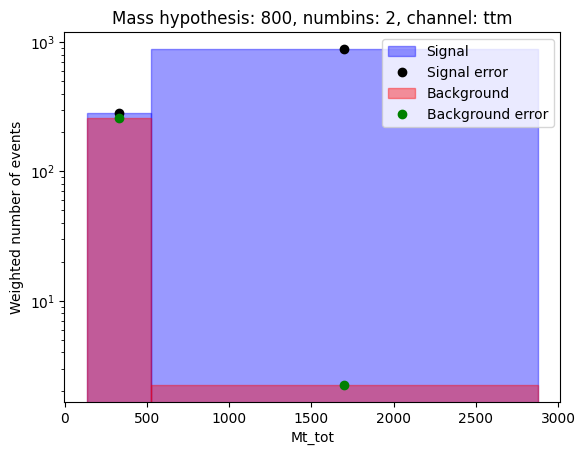

In [17]:
_=binmaker_rightleft(All_channel_dict['ttm'], 'Mt_tot', 800, X=0.2, plot=True, Channelname='ttm')

In [ ]:
# plot_average_significance_withpd(All_channel_dict, ['Mt_tot', 'scores'], model_info_list, ['binmaker_rightleft'], X=0.15, hide_errorbars=True, print_AUC=True)

In [18]:


def bin_uncertainty2(signal_height, background_height, sig_std, back_std, significance):
    """
    Calculates the uncertainty in the significance calculation. 

    Parameters:
    signal_height (float): The signal height of the bin.
    background_height (float): The background height of the bin.
    sig_std (float): The standard deviation of the signal.
    back_std (float): The standard deviation of the background.
    significance (float): The calculated significance.

    Returns:
    float: The calculated uncertainty in the significance.
    """    
    numbins=len(signal_height)
    sumdfds=0
    sumdfdb=0

    for i in range(numbins):
        
        dfds=signal_height[i] / (background_height[i] * significance + 1e-8)
        sumdfds+=(dfds * sig_std[i])**2

        dfdb=-0.5*(signal_height[i]**2) / (background_height[i]**2 * significance + 1e-8)
        sumdfdb+=(dfdb * back_std[i])**2
    uncertainty=np.sqrt(sumdfds+sumdfdb)
    return uncertainty
    

def find_significance(data, channels, xvariable, masshyp, X=0.2, plot=False, binmakertype='binmaker_rightleft'):
    """
    For each channel, calculates the significance and its uncertainty for a specific mass hypothesis. 

    Parameters:
    data (dict): A dictionary where each key is a channel and its corresponding value is a nested 
                 dictionary with keys 'background' and 'signal', each associated with a DataFrame containing 
                 features for each instance in the corresponding category.
    channels (list): A list of channels to calculate significance for.
    xvariable (str): A string denoting the variable to be plotted on the x-axis.
    masshyp (float): The mass hypothesis under consideration.
    X (float, optional): A scalar value used in the calculation of significance. Default is 0.2.
    plot (bool, optional): A boolean value indicating whether to plot the results. Default is False.
    binmakertype (str, optional): A string specifying the method used to create bins for calculating 
                                  significance. Can be either 'binmaker_rightleft' or 'binmaker_constsignal'. 
                                  Default is 'binmaker_rightleft'.

    Returns:
    significance_pd (DataFrame): A DataFrame with calculated significances for each channel.
    uncertainty_pd (DataFrame): A DataFrame with calculated uncertainties for each channel.
    """
    significance_pd=pd.DataFrame(columns=channels)
    uncertainty_pd=pd.DataFrame(columns=channels)
    for channel in channels:
        if binmakertype=='binmaker_rightleft':
            bin_indices, signal_height, background_height, signal_error, background_error =binmaker_rightleft(data[channel], xvariable, masshyp, X=X,  plot=False, Channelname =channel)
        elif binmakertype == 'binmaker_constsignal':
            bin_indices, signal_height, background_height, signal_error, background_error =binmaker(data[channel], 30, xvariable, masshyp, X=X,  plot=False)
        else:
            raise ValueError("binmakertype not recognized: " + binmakertype)
        
        s1 = signal_height / np.sqrt(background_height + 1e-8)  # Adding a small constant

        significance2=np.sum(s1**2)
        significance_pd.at[0, channel]=np.sqrt(significance2)

        uncertainty=bin_uncertainty2(signal_height, background_height, signal_error, background_error, np.sqrt(significance2))
        uncertainty_pd.at[0, channel]=uncertainty



    return significance_pd, uncertainty_pd

def find_significance2(data, channels, xvariable, masshyp, model_name, model_class, path, vars_list, X=0.2, plot=False, scaler=None, binmakertype='binmaker_rightleft'):
    """
    Similar to find_significance, but uses a deep learning model to calculate scores, 
    and subsequently the significance and its uncertainty, for a specific mass hypothesis.

    Parameters:
    data (dict): A dictionary where each key is a channel and its corresponding value is a nested 
                 dictionary with keys 'background' and 'signal', each associated with a DataFrame containing 
                 features for each instance in the corresponding category.
    channels (list): A list of channels to calculate significance for.
    xvariable (str): A string denoting the variable to be plotted on the x-axis.
    masshyp (float): The mass hypothesis under consideration.
    model_name (str): The name of the trained model to load for score calculation.
    path (str): The directory where the trained model is located.
    vars_list (list): A list of feature names that the model uses for prediction. 
    X (float, optional): A scalar value used in the calculation of significance. Default is 0.2.
    plot (bool, optional): A boolean value indicating whether to plot the results. Default is False.
    scaler (object, optional): An instance of a preprocessing scaler if the data needs to be scaled. 
                               Default is None, indicating that no scaling is required.
    binmakertype (str, optional): A string specifying the method used to create bins for calculating 
                                  significance. Can be either 'binmaker_rightleft' or 'binmaker_constsignal'. 
                                  Default is 'binmaker_rightleft'.

    Returns:
    significance_pd (DataFrame): A DataFrame with calculated significances for each channel.
    uncertainty_pd (DataFrame): A DataFrame with calculated uncertainties for each channel.
    """
    significance_pd=pd.DataFrame(columns=channels)
    uncertainty_pd=pd.DataFrame(columns=channels)



    dnn_score_dict=get_dnn_score_dict_torch_simple(data,model_class, vars_list,masshyp, scaler=scaler)

    
    for channel in tqdm(channels, desc='channel find_significance2, masshyp:' + str(masshyp), disable=True):
        try:
            if binmakertype=='binmaker_rightleft':
                bin_indices, signal_height, background_height, signal_error, background_error=binmaker_rightleft(dnn_score_dict[channel], xvariable, masshyp, X=X,  plot=False, Channelname =channel)
            elif binmakertype == 'binmaker_constsignal':
                bin_indices, signal_height, background_height, signal_error, background_error=binmaker(dnn_score_dict[channel], 30, xvariable, masshyp, X=X,  plot=False)
            else:
                raise ValueError("binmaker type not recognized: " + binmakertype)
        except ValueError as ve:
            print(f"Skipping binmaker for channel {channel} due to error: {str(ve)}")
            continue
        
        s1 = signal_height / np.sqrt(background_height + 1e-8)  # Adding a small constant

        significance2=np.sum(s1**2)
        significance_pd.at[0, channel]=np.sqrt(significance2)  # Set value at specific cell

        uncertainty=bin_uncertainty2(signal_height, background_height, signal_error, background_error, np.sqrt(significance2))
        uncertainty_pd.at[0, channel]=uncertainty


    return significance_pd, uncertainty_pd


def get_dnn_score_dict_torch_simple(data_dict_dnn, model_class, vars_list,masshyp, scaler=None):
    """
    Given a dictionary containing data for various channels and a deep learning model, this method computes the model's
    scores for each event (particle collision). The method also modifies the original dictionary to 
    include these scores.

    Parameters:
    data_dict_dnn (dict): A dictionary where each key is a channel and its corresponding value is a nested dictionary 
                          with keys 'background' and 'signal', each associated with a DataFrame containing features for 
                          each instance in the corresponding category. 
    model_name (str): The name of the trained model to load for score calculation.
    path (str): The directory where the trained model is located.
    vars_list (list): A list of feature names that the model uses for prediction. 
                      It should include 'signal_label' and 'weightNorm' but they will be removed inside the function.
    masshyp (float): The mass hypothesis under consideration.
    scaler (object, optional): An instance of a preprocessing scaler if the data needs to be scaled. 
                               The default is None, indicating that no scaling is required.

    Returns:
    dict: The modified dictionary where each 'background' and 'signal' DataFrame now includes a new 'scores' column 
          containing the model's scores for each event.
    """

    
    dict_copy = deepcopy(data_dict_dnn)
    vars_list_copy= vars_list.copy()
    vars_list_copy.remove('signal_label')
    vars_list_copy.remove('weightNorm')

   
    model=model_class
    model.to(device)
    model.eval()

    for channel in  tqdm(dict_copy.keys(), desc='channel', disable=True):
        
        data_background = pd.DataFrame.from_dict(dict_copy[channel]['background'])
        data_signal = pd.DataFrame.from_dict(dict_copy[channel]['signal'])
        data_background['mass_hyp']=masshyp
        data_all_concat = pd.concat([data_background, data_signal])

        data_all_concat['channel']=channelsd[channel]
        # print("data_all_concat channel shape: ", data_all_concat['channel'].shape)
        additional=data_all_concat[additionalinput_vars]
        additional=additional.to_numpy()

        pretrained=data_all_concat[renamed_old_input_names]
        pretrained=pretrained.to_numpy()

        # data_all_concat = data_all_concat[vars_list_copy]
        data_all_concat = data_all_concat.to_numpy()

        # data_all_concat_tensor = torch.tensor(data_all_concat).float()
        # pretrained_input = data_all_concat_tensor[:, :train_inputdata.shape[1]].to(device)
        # additional_input = data_all_concat_tensor[:, train_inputdata.shape[1]:].to(device)
        pretrained_input = torch.tensor(pretrained).float().to(device)
        additional_input = torch.tensor(additional).float().to(device)

        # print("pretrained_input.shape: ", pretrained_input.shape)
        # print("additional_input.shape: ", additional_input.shape)


        # data_all_concat = torch.
        # if scaler is not None:
        #     data_all_concat=scaler.transform(data_all_concat)

        
        
        with torch.no_grad():
            output=model(pretrained_input, additional_input)
        scores=output.cpu().numpy()

        dict_copy[channel]['background']['scores']=scores[:len(data_background)].flatten()
        dict_copy[channel]['signal']['scores']=scores[len(data_background):].flatten()

    return dict_copy

100%|██████████| 16/16 [00:09<00:00,  1.70it/s]
/tmp/ddemler/ipykernel_33023/3853475340.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


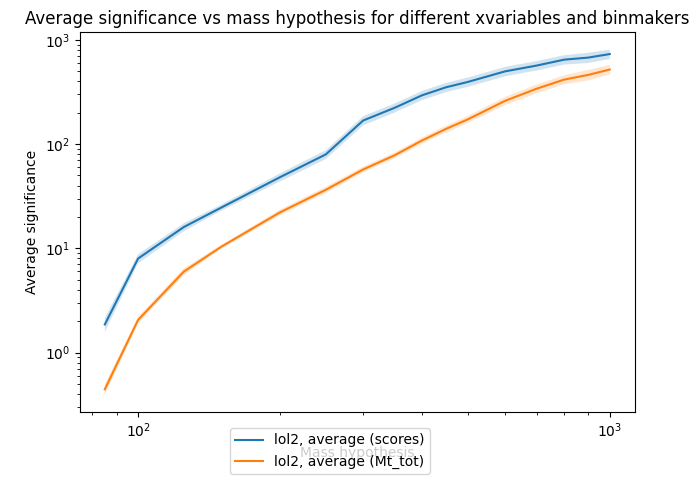

In [21]:
def plotsignificance(All_channel_dict, xvars ):
    mass_hyp_values = np.unique(All_channel_dict['tte']['signal']['mass_hyp'])
    model_class= TransferCustomKinematicNet(feature_extractor, additional_input_size=len(additionalinput_vars), new_hidden_layers=[128, 64, 32])
    model_class.load_state_dict(torch.load(newmodelsavepath))

    save_name='lol2'
    save_path='lol'

    input_vars=list(All_channel_dict['tee']['background'].keys())

    fig, ax = plt.subplots()
    legend_ax = fig.add_axes([0, 0, 1, 0.1])
    for xvar in xvars:
        avg_scores=[]
        avg_uncertainties=[]
        for mass_hyp_value in tqdm(mass_hyp_values, total=len(mass_hyp_values)):
            if xvar=="scores":
                sig_curr, uncer_curr = find_significance2(All_channel_dict, channels_names, xvar, mass_hyp_value, save_name, model_class, save_path, input_vars) 
            else:
                sig_curr, uncer_curr = find_significance(All_channel_dict, channels_names, xvar, mass_hyp_value)
            avg_score = sig_curr.mean(axis=1).values[0]
            avg_uncertainty = uncer_curr.mean(axis=1).values[0]

            avg_scores.append(avg_score)
            avg_uncertainties.append(avg_uncertainty)
            
        ax.plot(mass_hyp_values, avg_scores, label=f'{save_name}, average ({xvar})')
        ax.fill_between(mass_hyp_values, np.subtract(avg_scores, avg_uncertainties), np.add(avg_scores, avg_uncertainties), alpha=0.2)

    ax.set_xlabel('Mass hypothesis')
    ax.set_ylabel('Average significance')
    ax.set_title('Average significance vs mass hypothesis for different xvariables and binmakers')
    ax.set_xscale('log')
    ax.set_yscale('log')

    handles, labels = ax.get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc='center')

    # Hide the axes of the legend
    legend_ax.axis('off')

    # Adjust subplot parameters and then call tight_layout
    plt.subplots_adjust(bottom=-1)  # Adjust this value to suit your needs
    plt.tight_layout()

    plt.show()

datacopy=deepcopy(All_channel_dict)
plotsignificance(datacopy, [ 'scores','Mt_tot'])
            

100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


avg scores for  Mt_tot :  [0.437028558951076, 2.0066661383176863, 5.8820100080734266, 10.251964247040807, 21.229734160754766, 34.7258392812556, 54.051190593976074, 72.32864606000052, 97.08571010503044, 120.47894145850856, 146.29655173469524, 201.4676675461061, 242.5175064798155, 293.399286512395, 322.74745302580095, 346.56647538625936]


100%|██████████| 16/16 [01:16<00:00,  4.78s/it]


avg scores for  scores :  [1.5775615596802317, 7.270060869765006, 15.127083253180274, 22.893306099212303, 43.56438669401844, 65.48480073788112, 101.1143242675347, 138.34884165299678, 173.2758644373514, 207.21345216937328, 238.75602674667897, 291.10101448584237, 324.55603549644763, 365.2695107989378, 369.9111898136535, 421.50171406982975]


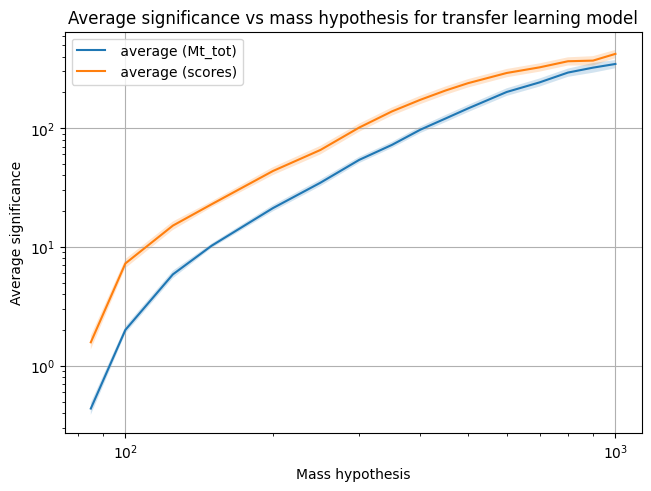

In [19]:
# plt.style.use('ggplot')
plt.style.use('default')
def plotsignificance(All_channel_dict, xvars ):
    mass_hyp_values = np.unique(All_channel_dict['tte']['signal']['mass_hyp'])
    model_class= TransferCustomKinematicNet(feature_extractor, additional_input_size=len(additionalinput_vars), new_hidden_layers=[128, 64, 32])
    model_class.load_state_dict(torch.load(newmodelsavepath))

    save_name='transfer'
    save_path='lol'

    input_vars=list(All_channel_dict['tee']['background'].keys())

    fig, ax = plt.subplots(constrained_layout=True)
    # legend_ax = fig.add_axes([0, 0, 1, 0.1])
    for xvar in xvars:
        avg_scores=[]
        avg_uncertainties=[]
        for mass_hyp_value in tqdm(mass_hyp_values, total=len(mass_hyp_values)):
            if xvar=="scores":
                sig_curr, uncer_curr = find_significance2(All_channel_dict, channels_names, xvar, mass_hyp_value, save_name, model_class, save_path, input_vars, X=0.15) 
            else:
                sig_curr, uncer_curr = find_significance(All_channel_dict, channels_names, xvar, mass_hyp_value, X=0.15)
            avg_score = sig_curr.mean(axis=1).values[0]
            avg_uncertainty = uncer_curr.mean(axis=1).values[0]

            avg_scores.append(avg_score)
            avg_uncertainties.append(avg_uncertainty)
            
        ax.plot(mass_hyp_values, avg_scores, label=f' average ({xvar})')
        ax.fill_between(mass_hyp_values, np.subtract(avg_scores, avg_uncertainties), np.add(avg_scores, avg_uncertainties), alpha=0.2)
        print("avg scores for ", xvar, ": ", avg_scores)

    ax.set_xlabel('Mass hypothesis')
    ax.set_ylabel('Average significance')
    ax.set_title('Average significance vs mass hypothesis for transfer learning model')
    ax.grid()
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Add legend to the existing ax
    ax.legend(loc='upper left')

    plt.show()

datacopy=deepcopy(All_channel_dict)
plotsignificance(datacopy, [ 'Mt_tot', 'scores',])


            

In [ ]:
print(list(np.unique(All_channel_dict['tte']['signal']['mass_hyp'])))

[85.0, 100.0, 125.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0]


In [ ]:
def get_dnn_score_dict_torch_simple(data_dict_dnn, model_class, vars_list,masshyp, scaler=None):
    """
    Given a dictionary containing data for various channels and a deep learning model, this method computes the model's
    scores for each event (particle collision). The method also modifies the original dictionary to 
    include these scores.

    Parameters:
    data_dict_dnn (dict): A dictionary where each key is a channel and its corresponding value is a nested dictionary 
                          with keys 'background' and 'signal', each associated with a DataFrame containing features for 
                          each instance in the corresponding category. 
    model_name (str): The name of the trained model to load for score calculation.
    path (str): The directory where the trained model is located.
    vars_list (list): A list of feature names that the model uses for prediction. 
                      It should include 'signal_label' and 'weightNorm' but they will be removed inside the function.
    masshyp (float): The mass hypothesis under consideration.
    scaler (object, optional): An instance of a preprocessing scaler if the data needs to be scaled. 
                               The default is None, indicating that no scaling is required.

    Returns:
    dict: The modified dictionary where each 'background' and 'signal' DataFrame now includes a new 'scores' column 
          containing the model's scores for each event.
    """

    
    dict_copy = deepcopy(data_dict_dnn)
    vars_list_copy= vars_list.copy()
    vars_list_copy.remove('signal_label')
    vars_list_copy.remove('weightNorm')

   
    model=model_class
    model.eval()

    for channel in  tqdm(dict_copy.keys(), desc='channel', disable=True):
        
        data_background = pd.DataFrame.from_dict(dict_copy[channel]['background'])
        data_signal = pd.DataFrame.from_dict(dict_copy[channel]['signal'])
        data_background['mass_hyp']=masshyp
        data_all_concat = pd.concat([data_background, data_signal])
        # data_all_concat = data_all_concat[vars_list_copy]
        data_all_concat = data_all_concat.to_numpy()

        data_all_concat_tensor = torch.tensor(data_all_concat).float()
        pretrained_input = data_all_concat_tensor[:, :train_inputdata.shape[1]].to(device)
        additional_input = data_all_concat_tensor[:, train_inputdata.shape[1]:].to(device)

        data_all_concat = data_all_concat.to_numpy()
        if scaler is not None:
            data_all_concat=scaler.transform(data_all_concat)

        
        
        with torch.no_grad():
            output=model(pretrained_input, additional_input)
        scores=output.numpy()

        dict_copy[channel]['background']['scores']=scores[:len(data_background)].flatten()
        dict_copy[channel]['signal']['scores']=scores[len(data_background):].flatten()

    return dict_copy


def plot_average_significance_withpd(data, xvariables, model_info_df, binmakers, X=0.3, hide_errorbars=False, print_AUC=False):
    """
    This function calculates the average significance for different mass hypotheses for various machine learning models, 
    plots the average significance for each model, and prints the AUC if desired. The function is flexible and allows for 
    the use of different bin making methods and feature variables.

    Parameters:
    data (dict): A dictionary where each key is a channel and its corresponding value is a nested dictionary with keys 
                'background' and 'signal', each associated with a DataFrame containing features for each instance in 
                the corresponding category.
    xvariables (list): A list of feature names to be used in the calculation of significance. 
    model_info_df (DataFrame): A DataFrame containing information about the models to be used. Each row should contain 
                            the following columns: 'save_path' (directory where the trained model is saved), 'save_name' 
                            (name of the model), 'input_variables' (features used by the model), 'hidden_layers' 
                            (the architecture of the model's hidden layers), and 'scaler_path' (path to the model's 
                            preprocessing scaler).
    binmakers (list): A list of strings specifying the methods used to create bins for calculating significance. 
    X (float, optional): A scalar value used in the calculation of significance. Default is 0.3.
    hide_errorbars (bool, optional): If True, the function will not plot the error bars. Default is False.
    print_AUC (bool, optional): If True, the function will print the Area Under Curve (AUC) for each model. Default is False.

    Returns:
    None

    Note:
    The function plots the average significance and its uncertainty against the mass hypotheses for each model. The plots are 
    displayed in a single figure with log scales on both axes. A separate legend is created below the plot.

    Usage:
    The function should be called with the data dictionary, a list of feature names to be used as 'xvariables', a DataFrame 
    containing model information as 'model_info_df', and a list of bin making methods as 'binmakers'. The scalar value 'X', 
    'hide_errorbars', and 'print_AUC' can be specified if needed. If 'print_AUC' is True, the function will print the AUC for 
    each model after plotting the significance. If 'hide_errorbars' is True, the error bars will not be displayed in the plot.
    """

    mtot_run=False
    auc_dict = {}
    channels = data.keys()

    mass_hyp_values = np.unique(data['tte']['signal']['mass_hyp'])

    # Create separate axes for the legend
    fig, ax = plt.subplots()
    legend_ax = fig.add_axes([0, 0, 1, 0.1])

    # Loop over the models
    for _, row in tqdm(model_info_df.iterrows(), desc='model', disable=True):
        save_path, save_name, input_vars, hidden_layers, scaler_path = row['save_path'], row['save_name'], row['input_variables'], row['hidden_layers'], row['scaler_path']

        # Load model
        model_class = DNN_flexible(input_vars, hidden_layers)
        model_class.load_state_dict(load(save_path + save_name + '.pt'))

        # Load scaler
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)

        # Loop over the binmakers
        for binmakertype in binmakers:
            # Loop over the xvariables
            for xvariable in xvariables:
                if xvariable == 'Mt_tot':
                    if not mtot_run:
                        mtot_run=True
                    else: 
                        continue
                avg_scores = []
                avg_uncertainties = []

                pbar = tqdm(mass_hyp_values, disable=False)
                for mass_hyp_value in pbar:
                    pbar.set_description(f'Mass_hyps: {mass_hyp_value}, xvariable: {xvariable}, binmaker: {binmakertype}, model: {save_name}')

                    if xvariable == 'scores':
                        sig_curr, uncer_curr = find_significance2(data, channels, xvariable, mass_hyp_value, save_name, model_class, save_path, input_vars, X=X, plot=False, scaler=scaler, binmakertype=binmakertype)
                    else:
                        sig_curr, uncer_curr = find_significance(data, channels, xvariable, mass_hyp_value, X=X, plot=False, binmakertype=binmakertype)

                    avg_score = sig_curr.mean(axis=1).values[0]
                    avg_uncertainty = uncer_curr.mean(axis=1).values[0]

                    avg_scores.append(avg_score)
                    avg_uncertainties.append(avg_uncertainty)

                if print_AUC:
                    # Calculate the AUC for the current model
                    auc = np.trapz(avg_scores, x=mass_hyp_values)
                    auc_dict[save_name] = auc  # Save the AUC

                # Plot the average significance and its uncertainty
                ax.plot(mass_hyp_values, avg_scores, label=f'{save_name}, average ({xvariable}, {binmakertype})')
                if not hide_errorbars:
                    ax.fill_between(mass_hyp_values, np.subtract(avg_scores, avg_uncertainties), np.add(avg_scores, avg_uncertainties), alpha=0.2)
                

    if print_AUC:
        print("Ordered list of models by AUC:")
        for model, auc in sorted(auc_dict.items(), key=lambda item: item[1], reverse=True):
            print(f"Model: {model}, AUC: {auc}")


    ax.set_xlabel('Mass hypothesis')
    ax.set_ylabel('Average significance')
    ax.set_title('Average significance vs mass hypothesis for different xvariables and binmakers')
    ax.set_xscale('log')
    ax.set_yscale('log')

    handles, labels = ax.get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc='center')

    # Hide the axes of the legend
    legend_ax.axis('off')

    # Adjust subplot parameters and then call tight_layout
    plt.subplots_adjust(bottom=-1)  # Adjust this value to suit your needs
    plt.tight_layout()

    plt.show()